Hello everyone this is my first (touch on the surface) of object detection world 
I take the code from the course that I am taking now in coursera and modified the download_and_resize_image function to take also image paths. 

Tensorflow hub has a lot of pretrained models that can be used for inference. the data that this model was trained on contain the car class so we can use it to make inference in the test data here. 

In [ ]:
import os 
import pathlib

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time 

In [ ]:
# link to the model that we want to use 
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
# load the model specified by the module_handle
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# take a look at the available signatures for this particular model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F75889DBE90>}))

In [ ]:
#choose the 'default' signature for the object detector.
detector = model.signatures['default']
#detector = model.signatures['serving_default']

In [ ]:
def display_image(image):
    """
    Displays an image inside the notebook.
    This is used by download_and_resize_image()
    """
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url_path, new_width=256, new_height=256, display=False):
    '''
    Fetches an image online or locally stored, resizes it and saves it locally.
    
    Args:
        url_path (string) -- link to the image or path to a locall stored image 
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    
    
    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    if "https" in  str(url_path):
    
        # opens the given URL
        response = urlopen(url_path)

        # reads the image fetched from the URL
        image_data_res = response.read()

        # puts the image data in memory buffer
        image_data = BytesIO(image_data_res)
        
    else:
        image_data = url_path
        
        
    # opens the image
    pil_image = Image.open(image_data)

    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)

    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")

    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)

    print("Image downloaded to %s." % filename)

    if display:
        display_image(pil_image)
        
    return filename

Image downloaded to /tmp/tmpf71m44sl.jpg.


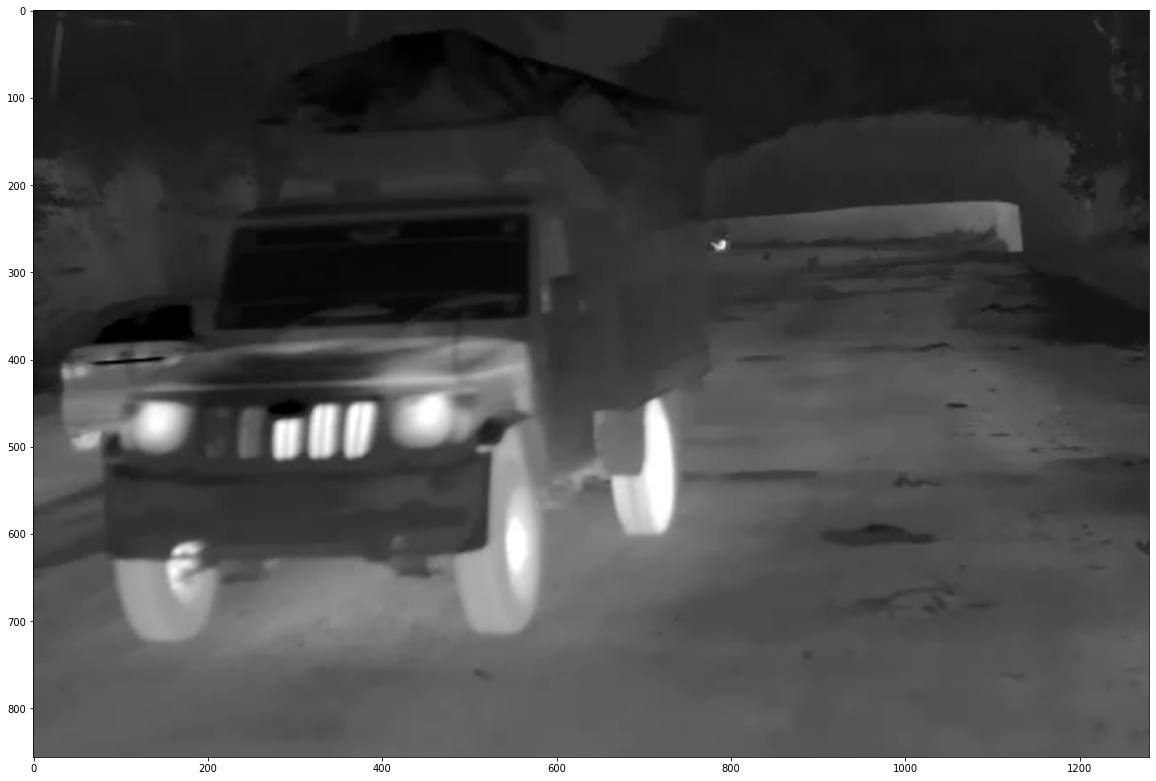

In [ ]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "/content/testcase11.bmp"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

In [ ]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    
    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path):
    '''
    Runs inference on a local file using an object detection model.
    
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

Found 100 objects.
Inference time:  0.26140809059143066


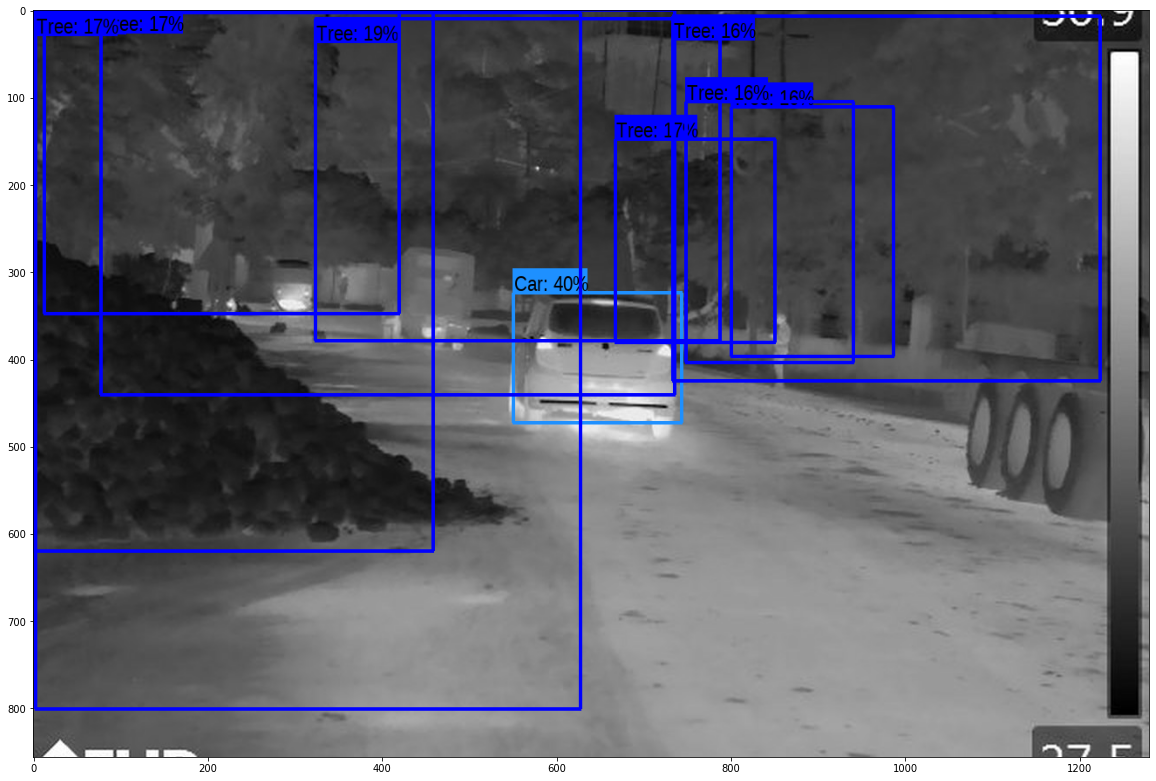

In [ ]:
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmp_lvy31ij.jpg.
Found 100 objects.
Inference time:  0.605919361114502


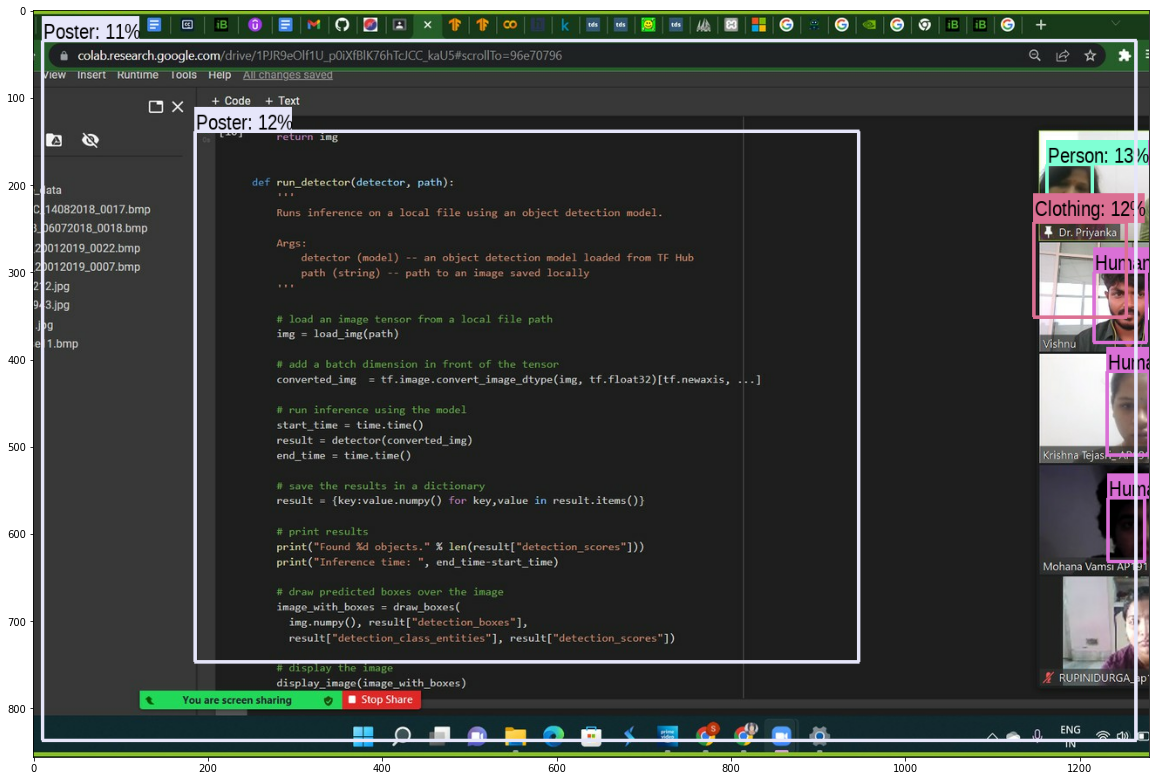

In [ ]:
test_img = pathlib.Path(r"/content/Screenshot (72).png")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmp25wz9qh_.jpg.
Found 100 objects.
Inference time:  0.29460954666137695


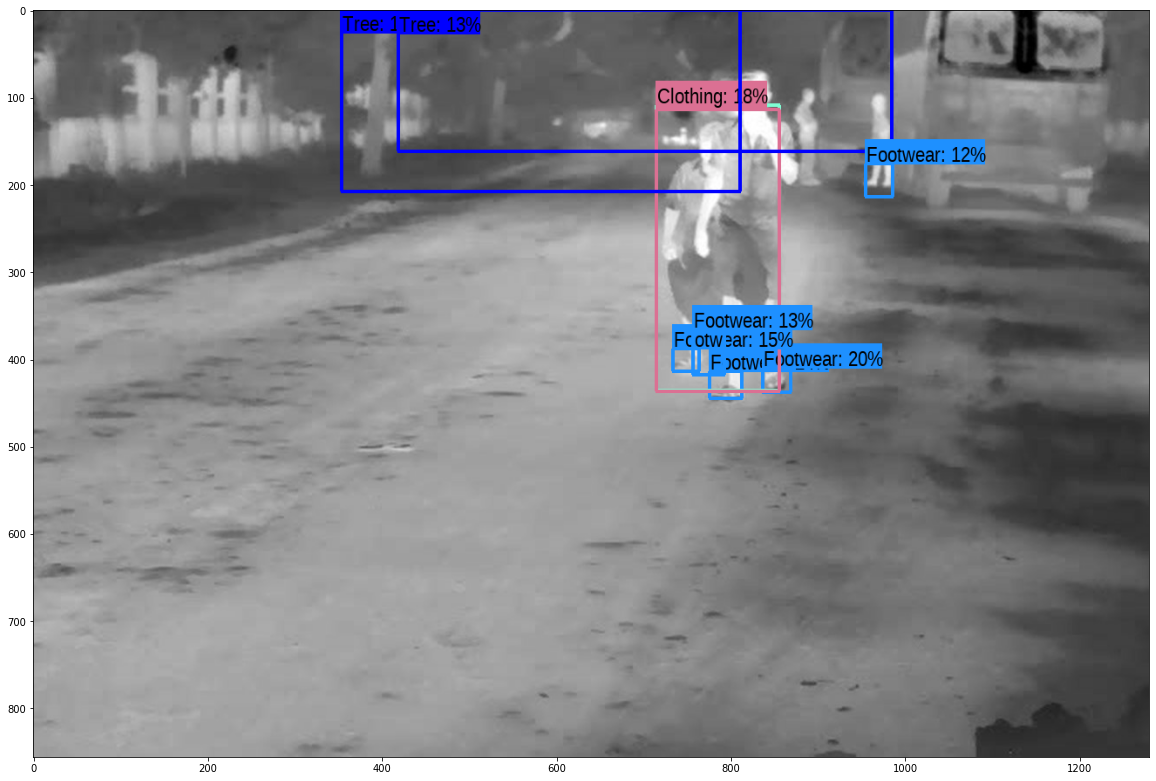

In [ ]:
test_img = pathlib.Path(r"/content/D2_FCB_06072018_0018.bmp")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmph4lvdolp.jpg.
Found 100 objects.
Inference time:  0.3054320812225342


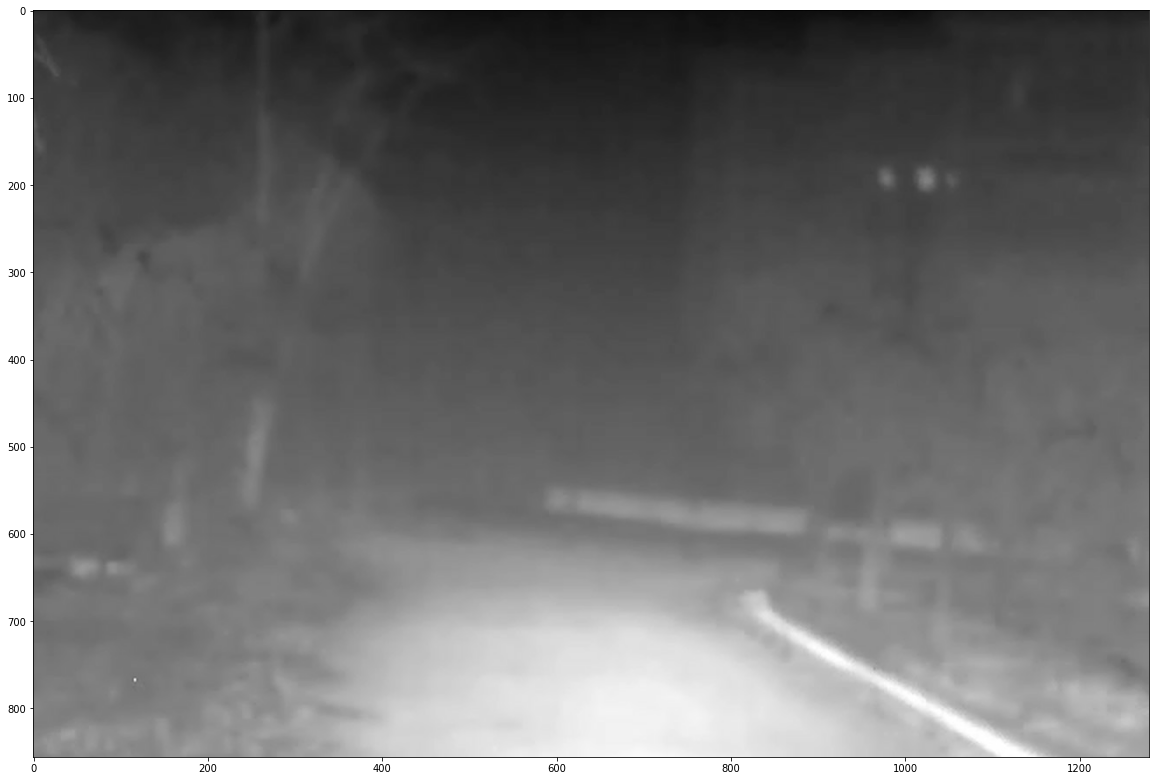

In [ ]:
test_img = pathlib.Path(r"/content/F8_DB_20012019_0022.bmp")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmp8__l1e06.jpg.
Found 100 objects.
Inference time:  0.27810120582580566


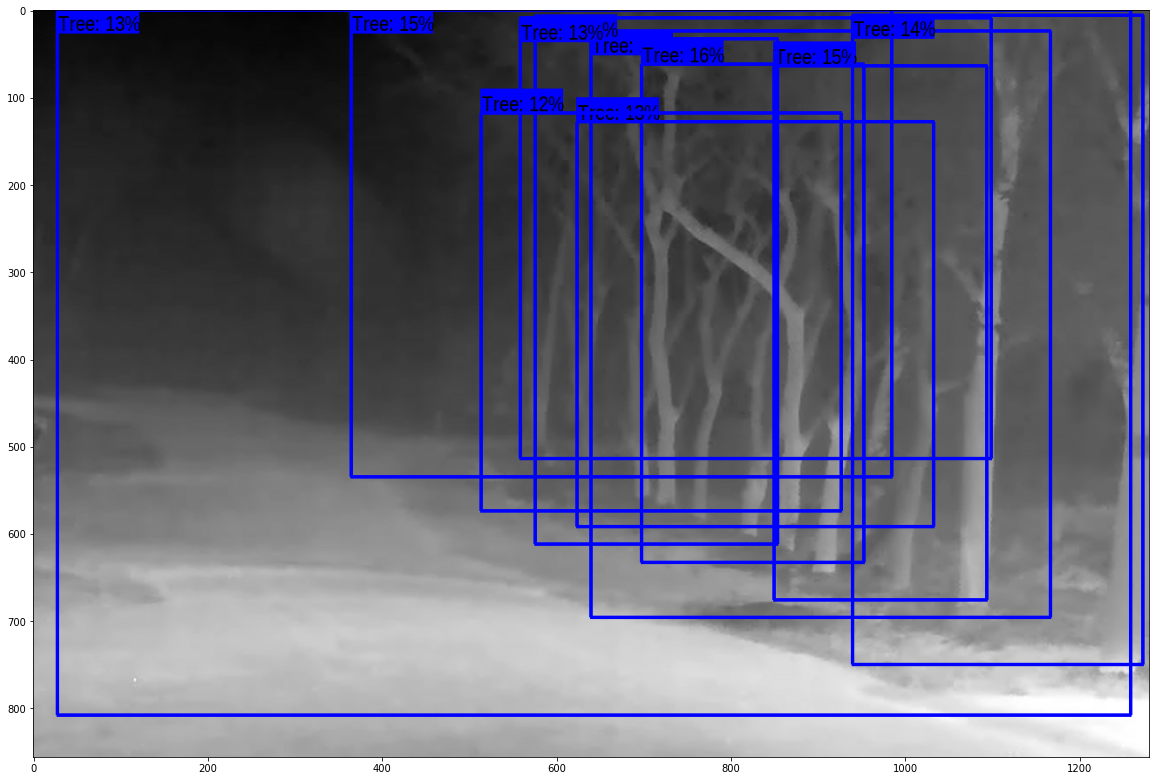

In [ ]:
test_img = pathlib.Path(r"/content/F9_DB_20012019_0007.bmp")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmpy1r9onx5.jpg.
Found 100 objects.
Inference time:  0.5851619243621826


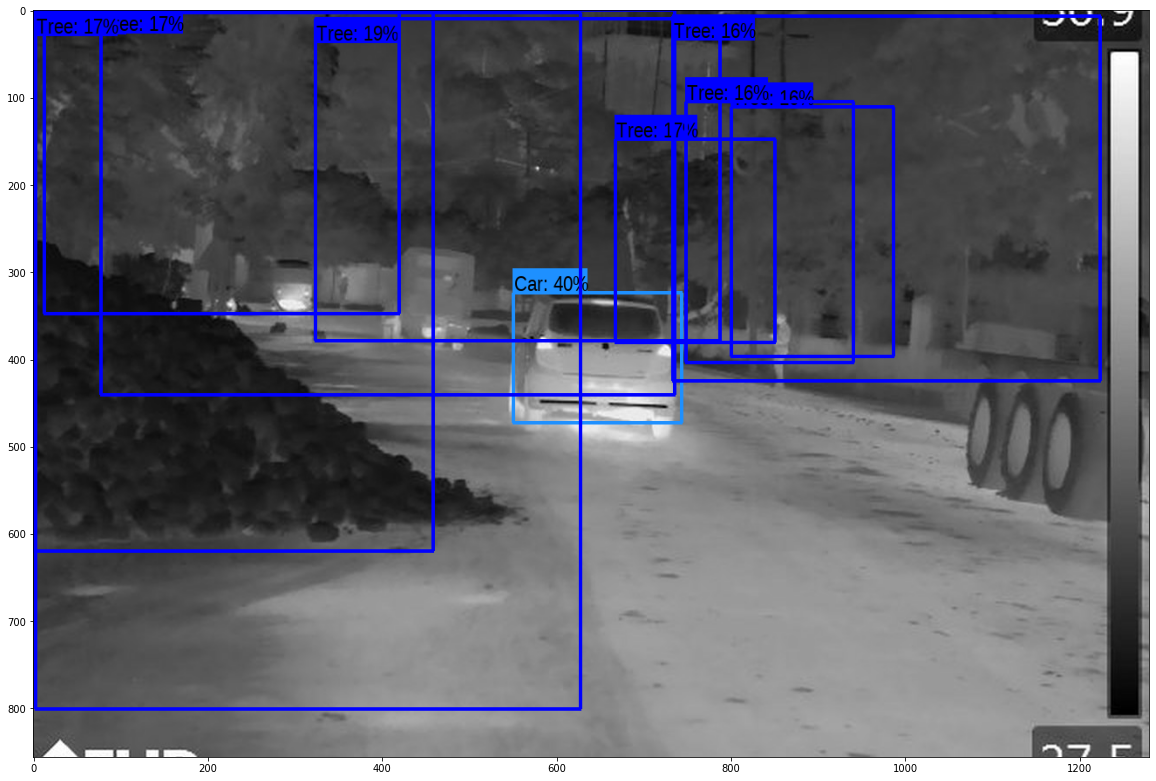

In [ ]:
test_img = pathlib.Path(r"/content/FLIR21212.jpg")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmpfhbrxqez.jpg.
Found 100 objects.
Inference time:  0.7369873523712158


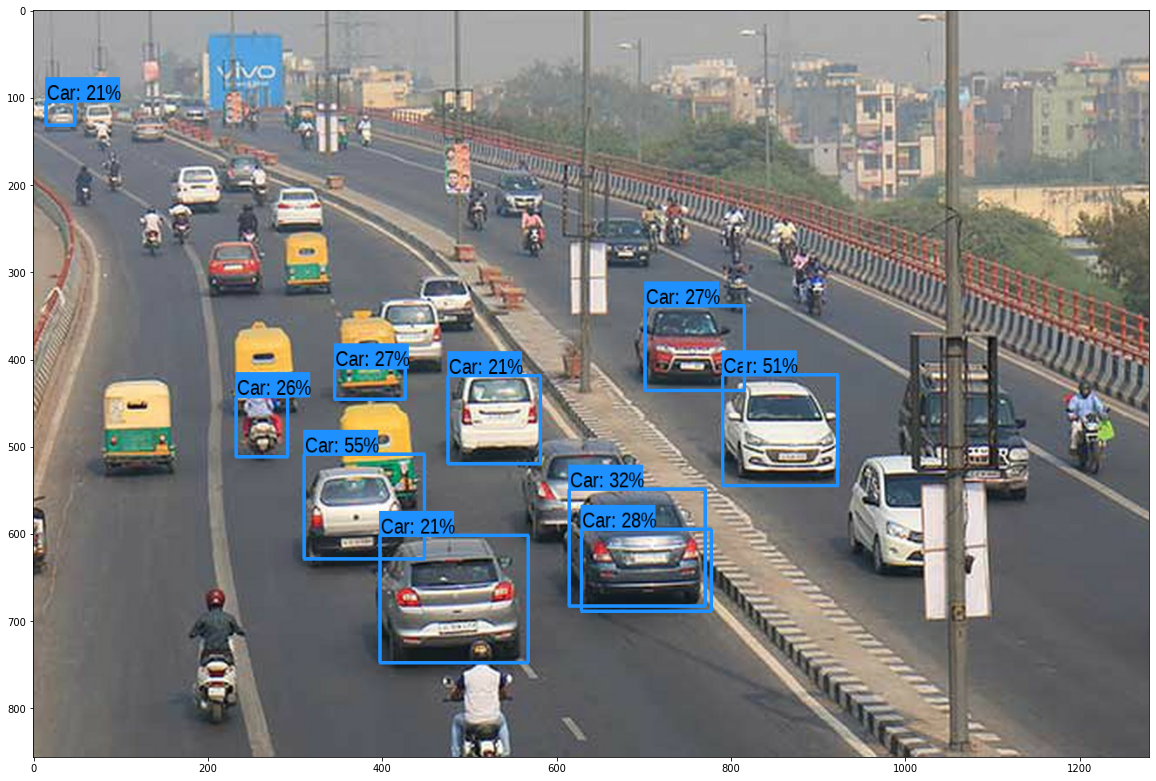

In [ ]:
test_img = pathlib.Path(r"/content/image1.jpg")
downloaded_image_path = download_and_resize_image(test_img, 1280, 856, False)
run_detector(detector, downloaded_image_path)